# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, Models
from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.maps import CountsSpectrum
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



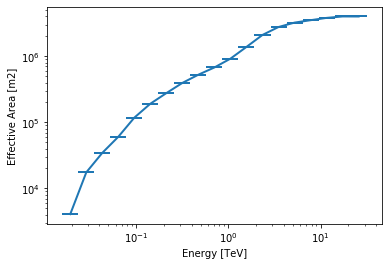

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

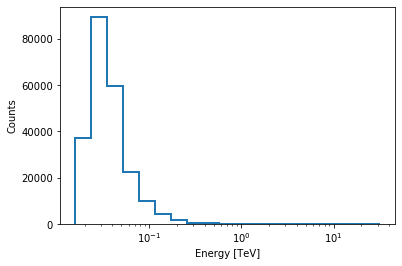

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Spatial Component
spatial_model = PointSpatialModel(
    lon_0="0 deg", lat_0="0 deg", frame="icrs"
)

In [10]:
# DM Flux
spectral_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [11]:
from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
#absorption_model = Absorption.read_builtin('dominguez')
#spectral_model = AbsorbedSpectralModel(spectral_model, absorption_model, redshift)

In [12]:
sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
models = Models([sky_model])

In [13]:
dataset = DMDatasetOnOff(
    aeff=aeff,
    models=models,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5
)

In [14]:
nuisance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC,
    sigmatau=0.01,
    # width=5 # default value / optional param 
)
dataset.nuisance = nuisance

## The SigmaVEstimator

**Enable inspection**

In [15]:
import logging
logging.basicConfig()
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")

**Instatiate estimator**

In [16]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels, background_model=bkg)

**Run estimator and fetch results**

In [17]:
%%time
# stat_profile_opts=dict(bounds=(-25, 100), nvalues=50)     # default param
# if nuisance = True the process takes the nuisance parameters into account
result = estimator.run(runs=3, nuisance=True)

INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 2.2893 	| LZero: 127.669 	| LMin:  125.379
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 79.4308 	| LMax: 207.100 	| LMin:  127.669
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: -29.966 	| SvBest: 0.000 	| SvUL: 14.338
DEBUG:gammapy.astro.darkmatter.utils:JBest: 5.097481213907987e+19 GeV2 / cm5
INFO:gammapy.astro.

DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: -6.577 	| SvBest: 0.000 	| SvUL: 6.302
DEBUG:gammapy.astro.darkmatter.utils:JBest: 2.3777873817566953e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.8906444055656786e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 2.3700 	| LZero: 127.669 	| LMin:  125.299
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 31.7126 	| LMax: 157.011 	| LMin:  125.299
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 17.468 	| SvBest: 17.468 	| SvUL: 43.531
DEBUG:gammapy.astro.darkmatter.utils:JBest: 4.2705860834484765e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.3059395715608053e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gamm

INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 1.8032 	| LZero: 109.127 	| LMin:  107.324
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 148.7344 	| LMax: 256.058 	| LMin:  107.324
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 13.126 	| SvBest: 13.126 	| SvUL: 29.735
DEBUG:gammapy.astro.darkmatter.utils:JBest: 4.066264633875618e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:8.920415045460567e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 3.6869 	| LZero: 109.127 	| LMin:  105.440
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 34.9237 	| LMax: 140.364 	| LMin:  105.440
DEBUG:gammapy

DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 171.8901 	| LMax: 279.781 	| LMin:  107.891
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 10.490 	| SvBest: 10.490 	| SvUL: 26.412
DEBUG:gammapy.astro.darkmatter.utils:JBest: 3.460072957814553e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:7.923568498570407e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 2.4625 	| LZero: 109.127 	| LMin:  106.665
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 202.4358 	| LMax: 309.101 	| LMin:  106.665
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 12.404 	| SvBest: 12.404 	| SvUL: 26.002
DEBUG:gammapy.astro.darkmatter.utils:JBest: 5.058663425729712e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:7.800502217611307e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:g

INFO:gammapy.astro.darkmatter.utils:Sigma v:2.0541147108153904e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 2
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 1.9707 	| LZero: 114.039 	| LMin:  112.068
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 819.3143 	| LMax: 933.353 	| LMin:  114.039
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: -4.052 	| SvBest: 0.000 	| SvUL: 2.315
DEBUG:gammapy.astro.darkmatter.utils:JBest: 3.471525361608366e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:6.94483773517622e-26 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 2
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.8410 	| LZero: 114.039 	| LMin:  113.198
DEBUG:gammapy.astro.darkmatter.ut

CPU times: user 4min 45s, sys: 1.6 s, total: 4min 47s
Wall time: 4min 48s


**Display results for channel b and run 1**

In [18]:
cols = ["mass", "sigma_v", "sv_ul", "sv_best", "j_best"]
result["runs"]["b"][2][cols]

mass,sigma_v,sv_ul,sv_best,j_best
GeV,cm3 / s,,,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,8.812171554971915e-25,29.373905183239717,0.0,4.005021328844967e+19
200.0,1.2770737647946104e-24,42.56912549315368,10.418582131846083,3.0982915766273634e+19
500.0,1.5723564059833917e-24,52.41188019944639,22.772182206848036,2.2505632763249615e+19
1000.0,4.7664749110759485e-25,15.888249703586496,4.7477903140615965,4.899105824147929e+19
5000.0,2.6426774543624896e-25,8.808924847874964,0.0,5.114904558336884e+19
10000.0,5.507483309934598e-25,18.35827769978199,0.0,2.2602376500304036e+19
50000.0,5.352696600425789e-25,17.842322001419294,0.0,4.2428357239258644e+19


**Plot likelihood profile for a specific fit**

In [19]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["Z"][0]["statprofile"][idx][0][0]

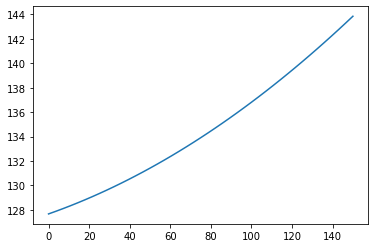

In [20]:
plt.plot(profile["values"], profile["stat"]);

## Obtained results

In [21]:
result["mean"]["b"]

mass,sigma_v,sigma_v_std,jfactor,jfactor_std
GeV,cm3 / s,cm3 / s,GeV2 / cm5,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,1.1887081931465127e-24,7.759822372291295e-25,4.423584903339712e+19,4.811536516201265e+18
200.0,1.1080183459938923e-24,5.968367122321883e-25,3.794176563827949e+19,7.722969439343911e+18
500.0,7.966492328578844e-25,5.839432260257227e-25,4.120948901479239e+19,1.3234301380726092e+19
1000.0,4.403832054826973e-25,1.4976652545957162e-25,3.4128276779363455e+19,1.2168757193230428e+19
5000.0,2.924465245962913e-25,1.6225570756576444e-25,4.73974641785841e+19,3.475191283751406e+18
10000.0,5.65855256662598e-25,2.603817916193982e-25,3.0242608249982513e+19,7.630588842353798e+18
50000.0,1.2344434886725412e-24,5.403418507405222e-25,3.698558750610803e+19,1.4103565416924246e+19


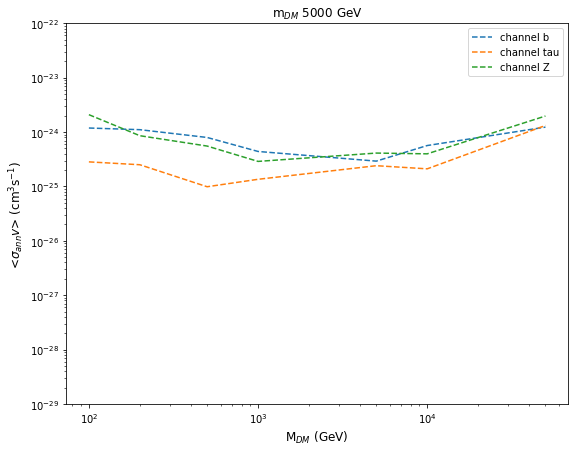

In [22]:
plt.figure(figsize=(9,7))
plt.ylim(1e-29, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();